In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [2]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/maya/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)

from ipynb.fs.defs.F01_Library_diversity import convert_variant_to_dict, single_fraction_enrichment

os.chdir("/mnt/c/Users/Maya/Documents/03_Kinases/code_check")

In [3]:
df = pd.read_csv('splimlib.zip', index_col=0)

In [4]:
# Set general restrictions stemming from SpliMLib library design
aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
splimlib = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

At this point, the read count distributions have been used to split the variants into five different grouping: two high activity (top & high), two low activity (bottom & low), plus the intermediate remaining variants.

In [5]:
print('Top: ', len(df.loc[(df['set'] == 'top')]))
print('High: ', len(df.loc[(df['set'] == 'high')]))
print('Medium: ', len(df.loc[(df['set'] == 'medium')]))
print('Low: ', len(df.loc[(df['set'] == 'low')]))
print('Bottom: ', len(df.loc[(df['set'] == 'bottom')]))
print('All: ', len(df))

Top:  30534
High:  5424
Medium:  140555
Low:  62816
Bottom:  266628
All:  505957


In [6]:
df.head()

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per,set,set_numeric
0,537.0,0.0,0.0,6,6V/7aP/8aA/9F/11V/13W,537.0,100.0,0.0,0.0,top,5
1,524.0,0.0,0.0,6,6V/7aP/8aA/9F/11I/13W,524.0,100.0,0.0,0.0,top,5
2,480.0,0.0,0.0,6,6K/7aI/8aA/9L/11I/13K,480.0,100.0,0.0,0.0,top,5
3,456.0,0.0,0.0,5,6A/7aL/8aΔ/9F/11I/13V,456.0,100.0,0.0,0.0,top,5
4,449.0,0.0,0.0,6,6F/7aI/8aA/9L/11I/13M,449.0,100.0,0.0,0.0,top,5


In [7]:
df.tail()

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per,set,set_numeric
505952,0.0,0.0,3.0,4,6P/7aG/8aA/9I/11Y/13K,3.0,0.0,0.0,100.0,bottom,1
505953,0.0,0.0,3.0,5,6I/7aG/8aΔ/9D/11G/13V,3.0,0.0,0.0,100.0,bottom,1
505954,0.0,0.0,3.0,6,6Y/7aK/8aA/9G/11Y/13I,3.0,0.0,0.0,100.0,bottom,1
505955,0.0,0.0,3.0,4,6Y/7aW/8aΔ/9I/11G/13I,3.0,0.0,0.0,100.0,bottom,1
505956,0.0,0.0,3.0,5,6I/7aI/8aΔ/9A/11F/13V,3.0,0.0,0.0,100.0,bottom,1


In [8]:
len(df.loc[(df['set_numeric'] >=4 ) & (df['high'] >= 51)])

29570

In [9]:
len(df.loc[(df['set_numeric'] >=4 )])

35958

In [10]:
len(df.loc[(df['high'] >= 10 )])

36654

In [11]:
len(df.loc[(df['high'] >= 10 ) & (df['set_numeric'] >=4 )])

35595

In [12]:
len(df.loc[(df['high'] < 10 ) & (df['set_numeric'] >=4 )])

363

In [13]:
df.loc[(df['high'] < 10 ) & (df['set_numeric'] >=4 )]

,high,med,low-t,Hamming,variants,total_reads,high_per,med_per,low_per,set,set_numeric
27672,9.0,0.0,3.0,6,6F/7aA/8aA/9P/11Y/13A,12.0,75.0,0.0,25.0,top,5
27673,9.0,0.0,3.0,5,6M/7aK/8aA/9W/11L/13I,12.0,75.0,0.0,25.0,top,5
27674,9.0,0.0,3.0,5,6P/7aW/8aA/9W/11F/13D,12.0,75.0,0.0,25.0,top,5
27675,9.0,0.0,3.0,6,6M/7aL/8aA/9P/11W/13A,12.0,75.0,0.0,25.0,top,5
27676,9.0,0.0,3.0,5,6L/7aL/8aΔ/9M/11F/13M,12.0,75.0,0.0,25.0,top,5
...,...,...,...,...,...,...,...,...,...,...,...
37227,4.0,2.0,4.0,4,6G/7aL/8aΔ/9L/11L/13I,10.0,40.0,20.0,40.0,high,4
37228,4.0,2.0,4.0,4,6K/7aY/8aA/9L/11L/13P,10.0,40.0,20.0,40.0,high,4
37229,4.0,2.0,4.0,5,6Y/7aL/8aA/9I/11F/13L,10.0,40.0,20.0,40.0,high,4
37230,4.0,2.0,4.0,5,6P/7aV/8aA/9W/11F/13D,10.0,40.0,20.0,40.0,high,4


In [14]:
df['variants']

0         6V/7aP/8aA/9F/11V/13W
1         6V/7aP/8aA/9F/11I/13W
2         6K/7aI/8aA/9L/11I/13K
3         6A/7aL/8aΔ/9F/11I/13V
4         6F/7aI/8aA/9L/11I/13M
                  ...          
505952    6P/7aG/8aA/9I/11Y/13K
505953    6I/7aG/8aΔ/9D/11G/13V
505954    6Y/7aK/8aA/9G/11Y/13I
505955    6Y/7aW/8aΔ/9I/11G/13I
505956    6I/7aI/8aΔ/9A/11F/13V
Name: variants, Length: 505957, dtype: object

## 1D enrichment heat maps: five split

In [15]:
from ipynb.fs.defs.F01_Library_diversity import make_composition_plot_per_position, single_fraction_enrichment, passes_restriction

In [16]:
aa_order = ['A','G','P','Y','D','K','M','V','I','L','F','W','Δ']
valid_pos = ['6', '7a', '8a', '9', '11', '13']

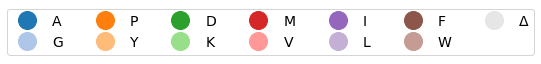

In [17]:
# Set palette and the order of amino acids for meaningful colors
pal = sns.color_palette("tab20")[:13]
pal[12] = (0.9, 0.9, 0.9) # set deletion to gray
sns.set_palette(pal)

fig, ax = plt.subplots(1,1, figsize=(1,1))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pal]
fig.legend(markers, aa_order, numpoints=1, loc='center left', ncol=7, markerscale=3, fontsize=14)
ax.axis('off')
plt.tight_layout()
#plt.savefig('Pie_legend.svg')
plt.show()

In the previous file (filtering positives), I categorised all variants for which we have good evidence into one of five sets: two with high activity, two with low and one intermediate. Here the 

In [18]:
def df_single_enrichment(df, colname = 'variants', restrict = False):
    """
    Input: df listing variants & their seq counts
    Output: dictionary with data aggregated by position, format: point_distrubution[pos][aa] = int
    """
    point_distribution = {pos: {aa: 0 for aa in aa_order} for pos in ['6', '7a', '8a', '9', '11', '13']}

    for v_short in df[colname]:
        # m_by_pos[position] = AA
        m_by_pos = convert_variant_to_dict(v_short)

        # in case we are considering relative enrichement, where some position is fixed:
        # the constrains has the form of a dictionary with allowed amino acids in tha tposition
        if not passes_restriction(m_by_pos, restrict):
            continue                

        for pos, aa in m_by_pos.items():  # need to do it this way so that WT positions are included
            point_distribution[pos][aa] += 1
    df_single = pd.DataFrame.from_dict(point_distribution).reindex(aa_order)
    
    return df_single

In [19]:
df_single_enrichment(df.loc[(df['set_numeric'] >=4 )])

,6,7a,8a,9,11,13
A,1960,1575,18059,1796,1389,2541
G,2252,1569,0,1124,1250,1767
P,4037,3437,0,2490,1496,2558
Y,2383,1436,0,1770,1589,1951
D,1065,655,0,1220,1145,1841
K,2725,2500,0,1692,1313,2115
M,3359,1922,0,3673,2815,3439
V,2392,2643,0,2301,2877,3640
I,2744,5354,0,5245,6944,4741
L,5397,7895,0,8096,8392,3920


In [20]:
def five_set_heatmaps(df, ax_lims, log_function, fname='', fsize=(12,3.5)):
    
    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]
    
    fig, axes = plt.subplots(1, 6,  figsize=fsize,
                            gridspec_kw={'wspace':0.3, 'hspace':0.3})

    for r in range(6):
        # plot: df/ideal
        if r == 0:
            df_restrict = df_single_enrichment(df)
        else:
            df_restrict = df_single_enrichment(df.loc[(df['set_numeric'] == r)])
        log_df = (df_restrict/(df_restrict.sum()/df_restrict.astype(bool).sum())).apply(log_function)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[r], cmap="RdBu_r", cbar=False)
        axes[r].set_title(r)
    
    axes[0].set_title('All')
    
    for ax in axes.flat:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if fname:
        plt.savefig(fname, dpi=300)
    plt.show()

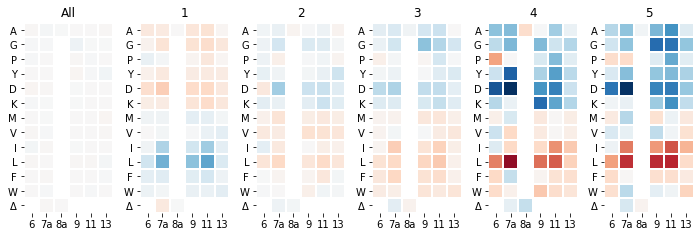

In [21]:
five_set_heatmaps(df, (-2,2), np.log2)

### Heatmap comparison for different cutoffs: active variants 1D & denominator

In [22]:
from ipynb.fs.defs.F01_Library_diversity import convert_variant_to_dict

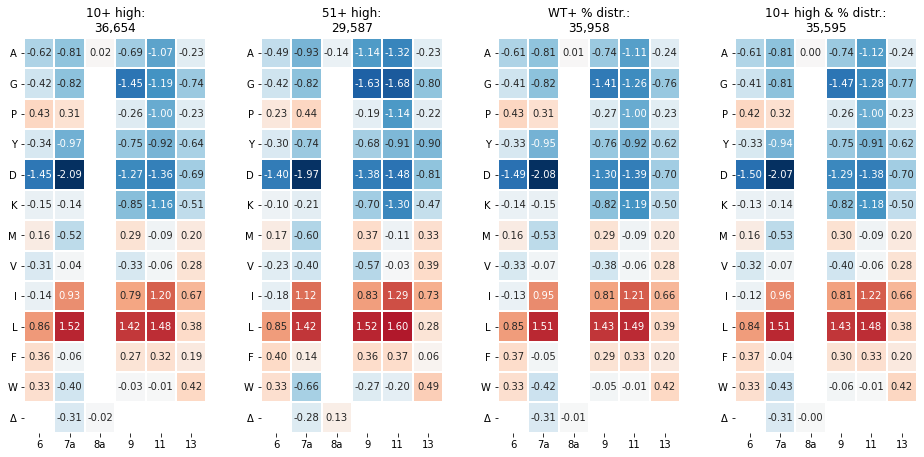

In [23]:
ax_lims = (-2, 2)
cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]



active_choices = {'10+ high': df.loc[(df['high'] >= 10)],
                 '51+ high': df.loc[(df['high'] >= 51)],
                 'WT+ % distr.': df.loc[(df['set_numeric'] >= 4)],
                 '10+ high & % distr.': df.loc[(df['set_numeric'] >= 4) & (df['high'] >= 10)]}

df_all_enrich = df_single_enrichment(df)
bottom_df = df_all_enrich/df_all_enrich.sum()

fig, axes = plt.subplots(1, len(active_choices),  figsize=(16,10), gridspec_kw={'wspace':0.3, 'hspace':0.3})
                  
i = 0
for name, df_plot in active_choices.items():
    df_restrict = df_single_enrichment(df_plot)
    
    # top plot: observed/ideal   
    log_df = (df_restrict/(df_restrict.sum()/df_restrict.astype(bool).sum())).apply(np.log2)   
    sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[i], cmap="RdBu_r", cbar=False, square=True, annot=True, fmt='.2f',)
    axes[i].set_title(name + ':\n' + '{:,}'.format(len(df_plot)))
    axes[i].tick_params(axis='y', labelrotation = 0)

    
    i+=1
    
plt.show()

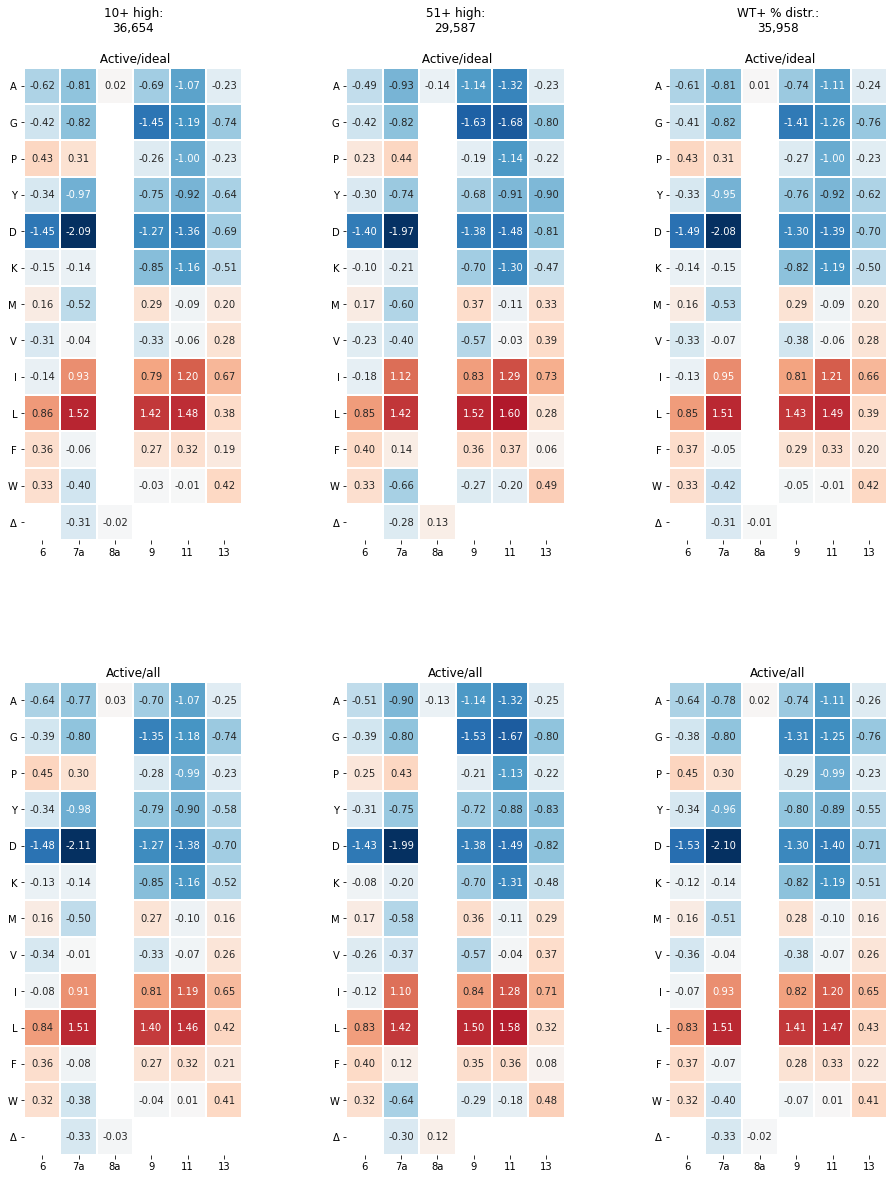

In [24]:
ax_lims = (-2, 2)
cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]



active_choices = {'10+ high': df.loc[(df['high'] >= 10)],
                 '51+ high': df.loc[(df['high'] >= 51)],
                 'WT+ % distr.': df.loc[(df['set_numeric'] >= 4)]}

df_all_enrich = df_single_enrichment(df)
bottom_df = df_all_enrich/df_all_enrich.sum()

fig, axes = plt.subplots(2, len(active_choices),  figsize=(16,20), gridspec_kw={'wspace':0.3, 'hspace':0.3})
                  
i = 0
for name, df_plot in active_choices.items():
    df_restrict = df_single_enrichment(df_plot)
    
    # top plot: observed/ideal   
    log_df = (df_restrict/(df_restrict.sum()/df_restrict.astype(bool).sum())).apply(np.log2)   
    sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[0][i], cmap="RdBu_r", cbar=False, square=True, annot=True, fmt='.2f',)
    axes[0][i].set_title(name + ':\n' + '{:,}'.format(len(df_plot)) + '\n\n Active/ideal')
    axes[0][i].tick_params(axis='y', labelrotation = 0)
    
    # bottom plot: observed/all variants
    top_df = df_restrict/df_restrict.sum()

    log_df = (top_df/bottom_df).apply(np.log2)   
    sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[1][i], cmap="RdBu_r", cbar=False, square=True, annot=True, fmt='.2f',)
    axes[1][i].set_title('Active/all')
    axes[1][i].tick_params(axis='y', labelrotation = 0)
    
    
    i+=1
    
plt.show()